<a href="https://colab.research.google.com/github/yagitgadhok/google-colab/blob/master/Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import files 
import io
import nltk
from bs4 import BeautifulSoup
import re
nltk.download("punkt")
nltk.download("stopwords")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train = files.upload()
train_tsv = pd.read_csv(io.BytesIO(train['labeledTrainData.tsv']), header = 0, delimiter='\t', quoting=3)
test = files.upload()
test_tsv = pd.read_csv(io.BytesIO(test['testData.tsv']), header = 0, delimiter='\t', quoting=3)

Saving labeledTrainData.tsv to labeledTrainData.tsv


In [ ]:
print('train dim', train_tsv.shape, 'test dim', test_tsv.shape)
train_tsv.iloc[0:4]

In [ ]:
def cleaning(raw_review):
  html_text = BeautifulSoup(raw_review, "html.parser").get_text()

  letters = re.sub("[^a-zA-Z]", " ", html_text)

  letters = letters.lower()

  tokens = nltk.word_tokenize(letters)

  stops = set(nltk.corpus.stopwords.words("english"))

  words =[w for w in tokens if not w in stops]

  words = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]

  return " ".join(words)

In [ ]:
train_tsv['clean'] = train_tsv['review'].apply(cleaning)
test_tsv['clean'] = test_tsv['review'].apply(cleaning)


In [ ]:
vectorizer = CountVectorizer(analyzer="word",
                             tokenizer= None,
                             preprocessor=None, 
                             stop_words=None,
                             max_features=20000,
                             min_df = 2,
                             ngram_range = (1,3)
                             )

In [ ]:
pipe = Pipeline([('vect', vectorizer)])

In [ ]:
train_bw =pipe.fit_transform(train_tsv['clean'])

test_bw = pipe.transform(test_tsv['clean'])

In [ ]:
lexi = vectorizer.get_feature_names()
lexi[:5]

['aag', 'aaron', 'ab', 'abandon', 'abbey']

In [ ]:
train_sum = pd.DataFrame(np.sum(train_bw,axis=0), columns=lexi)
train_sum.head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,abe,abhay,abid,abigail,abil,abil make,abl,abl get,abl make,abl see,abl watch,abli,aboard,abomin,aborigin,abort,abound,abraham,abraham lincoln,abroad,abrupt,absenc,absent,absolut,absolut aw,absolut brilliant,absolut hilari,absolut horribl,absolut love,absolut noth,...,yuen,yugoslavia,yup,yuppi,yuzna,yvonn,zabriski,zabriski point,zach,zack,zane,zani,zatoichi,zealand,zelah,zelah clark,zelda,zenia,zero,zero day,zero star,zeta,zeta jone,zhang,zip,zizek,zodiac,zodiac killer,zoe,zombi,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,24,28,28,26,562,25,1259,53,32,54,35,27,37,83,69,92,63,93,29,38,136,118,83,1850,29,35,42,23,93,154,...,21,28,26,32,25,25,40,36,22,21,70,38,33,47,43,34,28,31,390,44,32,38,37,37,23,85,45,26,27,1331,23,52,37,89,161,31,71,59,40,23


In [ ]:
kfold = StratifiedKFold(n_splits=5, random_state=2018)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
bnb = BernoulliNB()
gs_bnb = GridSearchCV(bnb, param_grid={'alpha':[0.03],
                                       'binarize':[0.001]},
                      verbose =1,cv = kfold, n_jobs =-1,
                      scoring ='roc_auc')
gs_bnb.fit(train_bw, train_tsv['sentiment'])
gs_bnb_best = gs_bnb.best_estimator_
print(gs_bnb.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'alpha': 0.03, 'binarize': 0.001}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


In [ ]:
submission = gs_bnb.predict_proba(test_bw)
print(gs_bnb.best_score_)

0.935587584


In [ ]:
coeff= gs_bnb_best.coef_
index = coeff.argsort()

In [ ]:
feature_name = np.array(pipe.named_steps['vect'].get_feature_names())
feature_name[index][0][:30]

In [ ]:
feature_name[index][0][-31::1]

In [ ]:
feature_name_comb = list(feature_name[index][0][:30]) + list(feature_name[index][0][-31::1])
index_comb = list(coeff[0][index[0][:30]])+ list(coeff[0][index][0][-31::1])

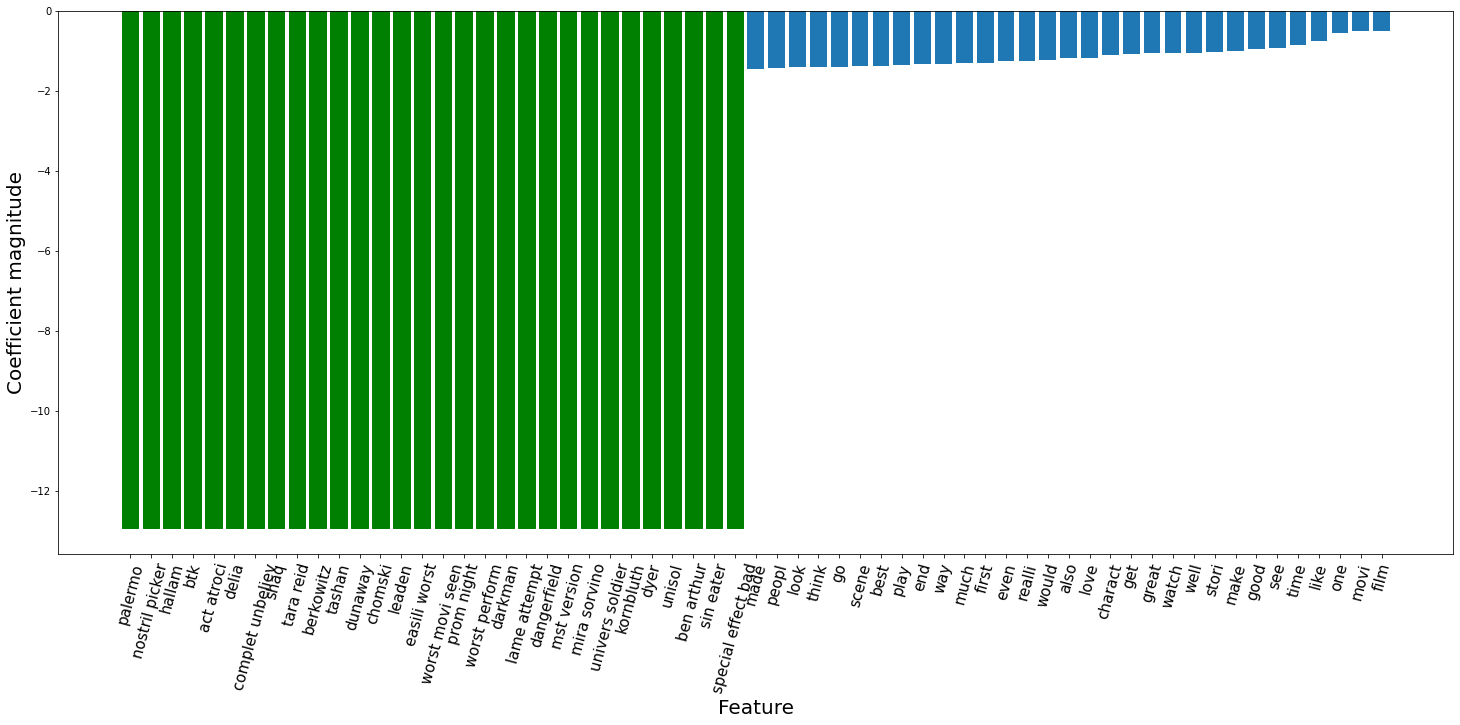

In [ ]:
plt.figure(figsize=(25,10))
barlist = plt.bar(list(i for i in range(61)), index_comb)
plt.xticks(list(i for i in range(61)), feature_name_comb, rotation=75, size = 15)
plt.ylabel('Coefficient magnitude', size =20)
plt.xlabel('Feature', size=20)

for i in range(30):
  barlist[i].set_color('g')

plt.show()

In [ ]:
sv = LinearSVC(random_state=2018)

param_grid2 = {
    'loss':['hinge'],
    'class_weight':[{1:1}],
    'C': [0.01]
}

gs_sv = GridSearchCV(sv, param_grid = [param_grid2], verbose = 1, cv = kfold, n_jobs = -1, scoring = 'roc_auc' )
gs_sv.fit(train_bw, train_tsv['sentiment'])
gs_sv_best = gs_sv.best_estimator_
print(gs_sv.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


{'C': 0.01, 'class_weight': {1: 1}, 'loss': 'hinge'}


In [ ]:
coefficients = gs_sv_best.coef_
index = coefficients.argsort()
feature_names = np.array(pipe.named_steps['vect'].get_feature_names())
feature_names[index][0][:30]
feature_names[index][0][-31::1]

In [ ]:
feature_names_comb = list(feature_names[index][0][:30]) + list(feature_names[index][0][-31::1])
index_comb = list(coefficients[0][index[0][:30]]) + list(coefficients[0][index[0][-31::1]])

In [ ]:
submission = gs_sv.predict(test_bw)
print(gs_sv.best_score_)

0.948018144


In [ ]:
plt.figure(figsize=(25,10))
barlist = plt.bar(list(i for i in range(61)), index_comb)
plt.xticks(list(i for i in range(61)),feature_names_comb,rotation=75,size=15)
plt.ylabel('Coefficient magnitude',size=20)
plt.xlabel('Features',size=20)

for i in range(30):
    barlist[i].set_color('g')
for i in range(30,61):
  barlist[i].set_color('r')

plt.show()

NameError: ignored